# Graph Neural Networks - Practicals 2


In [1]:
import torch
torch.manual_seed(0)
TORCH = torch.__version__.split('+')[0]
DEVICE = 'cu' + torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

!pip install -q torch-sparse torch-scatter torch-cluster torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{DEVICE}.html
!pip install -q torch-geometric
!pip install -q networkx==3.1 matplotlib tqdm torchmetrics ipywidgets

import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torch_geometric.nn as gnn
import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm

### [Again] Download Training Data

**Datasets**

When comparing Graph Neural Networks (GNNs) to other neural network architectures such as Fully-Connected Neural Networks (FCNNs) or Convolutional Neural Networks (CNNs), there are unique requirements for the data used in GNNs.

GNNs typically require two fundamental data points: a graph structure, which describes how nodes are connected, and a feature matrix, providing information associated with each node.

For the purpose of this tutorial, we aim to keep the focus on benchmarking and comparing various architectures. Therefore, we'll reduce the number of input features with `reduce_features` initially. This step will help us evaluate the efficiency and performance of our models in a more streamlined context.

In [2]:
from torch_geometric.datasets import TUDataset

def reduce_features(data):
    data.x = data.x.sum(dim=1, keepdim=True)
    return data

dataset = TUDataset(root='data/TUDataset', name='MUTAG', pre_transform=reduce_features)

### [Again] Explore dataset

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**:

In [3]:
# from ipywidgets import interact, IntSlider

# @interact(index=IntSlider(max=len(dataset)-1))
# def display_dataset_element(index):
#     g = to_networkx(dataset[index], to_undirected=True)
#     plt.title(f"Class: {dataset[index].y.item()}")
#     nx.draw(g, with_labels=True)
#     plt.show()

## [Again] Exploring Graph Classification with Graph Neural Networks

In this tutorial session, we will delve into the application of **Graph Neural Networks (GNNs) for graph classification**. Unlike node classification, graph classification is tasked with classifying entire graphs, given a **dataset of graphs**, based on their structural properties. Our aim is to generate embeddings for entire graphs in such a way that they are linearly separable for a given task.

A key part of this process is the training and evaluation of our model. We will use the `train_and_eval` function for this purpose:


In [17]:
def train_and_eval(model : nn.Module, dataset : Dataset, hparams: dict = {}) -> Tuple[nn.Module, float]:
    """
    Train and evaluate the model on the dataset.
    A boilerplate for training and evaluating a neural network.

    Args:
        model (nn.Module): The model to train and evaluate.
        dataset (Dataset): The dataset to train and evaluate on.
        hparams (dict): A dictionary of hyperparameters.

    Returns:
        nn.Module: The trained model with the best validation accuracy.
        float: The best validation accuracy.
    """

    hparams["num_epochs"] = hparams.get("num_epochs", 100)
    hparams["lr"] = hparams.get("lr", 0.01)
    hparams["batch_size"] = hparams.get("batch_size", 16)

    # shuffle dataset
    dataset = dataset.shuffle()
    train_sizes = {"ENZYMES": 540, "MUTAG": 150}
    sz = train_sizes[dataset.name]

    # init training and validation dataloaders
    dataloader_train = DataLoader(dataset[:sz], batch_size=hparams["batch_size"], shuffle=True)
    dataloader_val = DataLoader(dataset[sz:], batch_size=hparams["batch_size"])

    # init optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    criterion = nn.CrossEntropyLoss()

    # init metrics
    metric_loss_train = torchmetrics.MeanMetric()
    metric_accuracy_train = torchmetrics.Accuracy(task="multiclass", num_classes=dataset.num_classes)
    metric_accuracy_val = torchmetrics.Accuracy(task="multiclass", num_classes=dataset.num_classes)

    best_model_state = None
    best_val_acc = 0.0

    # training loop
    num_epochs = hparams["num_epochs"]
    epoch_bar = tqdm(list(range(num_epochs)), desc="Epochs" + " "*100)
    for epoch in epoch_bar:

        # training loop
        model.train()
        for data in dataloader_train:
            optimizer.zero_grad()
            logits = model(data.x, data.edge_index, data.batch)
            loss = criterion(logits, data.y)
            loss.backward()
            optimizer.step()

            metric_loss_train(loss)
            metric_accuracy_train(logits.argmax(dim=1), data.y)


        # evaluation loop
        model.eval()
        for data in dataloader_val:
            with torch.no_grad():
                logits = model(data.x, data.edge_index, data.batch)
                pred = logits.argmax(dim=1)
                metric_accuracy_val(pred, data.y)

        train_loss = metric_loss_train.compute().item()
        train_acc = metric_accuracy_train.compute().item()
        val_acc = metric_accuracy_val.compute().item()

        # progress bar
        epoch_bar.set_description("".join([
            f'Epoch: {epoch+1:03d} | ',
            f'Val Acc: {val_acc:.3f} | ',
            f'Train Acc: {train_acc:.3f} | ',
            f'Train Loss: {train_loss:.3f} | ',
            ]))

        # update best model
        if val_acc > best_val_acc:
            best_model_state = model.state_dict()
            best_val_acc = val_acc

    best_model = model
    best_model.load_state_dict(best_model_state)

    return best_model, best_val_acc

### [Again] Define our model

In [18]:
class SetConv(nn.Linear):
    """
    A simple linear layer that performs action on every node feature
    """

    def forward(self, x, edge_index):
        return super().forward(x)


class GraphNetModel(nn.Module):

    def __init__(self, num_features, num_classes, conv_layer_cls=None):
        super().__init__()

        # in case no gnnLayer is provided, use a simple linear layer
        if conv_layer_cls is None:
            conv_layer_cls = SetConv

        # first graph covolutional layer
        self.conv1 = conv_layer_cls(num_features, 32)

        # TODO🚀(optional):
        # - add more conv layers

        # last graph convolutional layer
        self.convL = conv_layer_cls(32, 32)

        # TODO🚀(optional):
        # - in many tutorials, the stantard dropout layer
        #    on **features** is used which can help
        #    with overfitting. Simlarly, the standard
        #    batch normalization can be used as well.
        # - `self.dropout = nn.Dropout(0.5)`

        # TODO🚀(optional):
        # - you might try to add batchnorm on features
        #   between the conv layers
        # - `self.batchnorm = nn.BatchNorm1d(32)`

        self.linear = nn.Linear(32, num_classes)

    def forward(self, x, edge_index, batch):

        # apply first layer and follow with ReLU
        x = self.conv1(x, edge_index).relu()

        # TODO🚀(optional):
        # - apply more conv layers

        x = self.convL(x, edge_index).relu()

        # this (set) pooling makes the function
        # invariant to the order of the nodes
        x = gnn.global_mean_pool(x, batch)

        # TODO🚀(optional):
        # add dropout or batchnorm of features
        # - `x = self.dropout(x)`

        # apply linear layer
        x = self.linear(x)

        return x

### [RUN] Initial Training and Evaluation without Incorporating Graph Convolutional Neural Network Layer

Let's begin our experiment with a simple run. This initial training and evaluation process does not involve any Graph Convolutional Neural Network layers. It allows us to gauge baseline performance and understand the effect of these layers when we introduce them later in the process.


In [19]:
model = GraphNetModel(dataset.num_features, dataset.num_classes)
model, val_accuracy = train_and_eval(model, dataset)

print("Model size:", sum(p.numel() for p in model.parameters()))
print("Best Accuracy:", val_accuracy)

Epoch: 100 | Val Acc: 0.553 | Train Acc: 0.693 | Train Loss: 0.620 | : 100%|██████████| 100/100 [00:04<00:00, 24.26it/s]                           

Model size: 1186
Best Accuracy: 0.5526315569877625


### [Task 1] Substructure Counting as Local Graph Parameters

For this task you might want to use model and network you build in the previous session.



In [58]:
def add_local_counting_features(data):
    nx = data.x.shape[0]

    # create abstraction of sparse adjacency matrix from edge_index
    A = tg.utils.to_torch_coo_tensor(data.edge_index)

    # also sparse identity matrix
    I = torch.sparse_coo_tensor(torch.stack([torch.arange(nx), torch.arange(nx)]), torch.ones(nx).float(), size=(nx, nx))

    # walks of length 3
    W3 = (A @ A @ A)
    # walks of length 4
    W4 = W3 @ A
    # walks of length 5
    W5 = W4 @ A
    # walks of length 6
    W6 = W5 @ A
    # walks of length 7
    W7 = W6 @ A
    # walks of length 8
    W8 = W7 @ A
    # walks of length 9
    W9 = W8 @ A
    # walks of length 10
    W10 = W9 @ A
    # walks of length 20
    W20 = W10 @ W10

    # closed walks of length 3
    C3 = (W3 * I).sum(dim=1)
    # closed walks of length 4
    C4  = (W4 * I).sum(dim=1)
    # closed walks of length 5
    C5  = (W5 * I).sum(dim=1)
    # closed walks of length 6
    C6  = (W6 * I).sum(dim=1)
    # closed walks of length 7
    C7  = (W7 * I).sum(dim=1)
    # closed walks of length 8
    C8  = (W8 * I).sum(dim=1)
    # closed walks of length 9
    C9  = (W9 * I).sum(dim=1)
    # closed walks of length 10
    C10 = (W10 * I).sum(dim=1)
    # closed walks of length 20
    C20 = (W20 * I).sum(dim=1)




    # add all features to the node features
    features = []

    # feature index 0 is the original node feature
    features.append(data.x)
    
    # feature index 1 
    features.append(C3)

    # feature index 2
    features.append(C4)



    #TODO🚀(optional):
    # - add more features here, however be careful, 
    #   the features should be equivariant, i.e.,
    #   the order of the nodes should not matter
    # - `features.append( ... )`



    # stack all features together
    data.x = torch.cat([
        feat.to_dense().view(-1, 1)
        for feat in features
    ], dim=1)

    return data

**test on our two graph:**

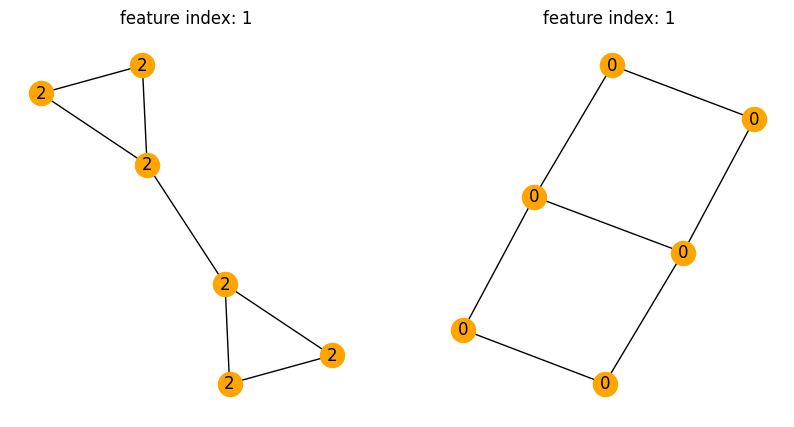

In [64]:
graph_G = nx.from_edgelist([(0,1), (1,2), (2,0), (3,4), (4,5), (5,3), (1,4)])
graph_H = nx.from_edgelist([(0,1), (1,2), (2,3), (3,4), (4,5), (5,0), (1,4)])

def from_networkx(G: nx.Graph) -> tg.data.Data:
    """Utility function"""
    data = tg.utils.from_networkx(G)
    data.x = torch.ones((G.number_of_nodes(), 1), dtype=torch.float)
    return data

def draw_graph_with_feature_vector(data_list, feature_index):
    c = len(data_list)
    plt.subplots(1, c, figsize=(c*5,5))
    for i, data in enumerate(data_list):
        feature_index = max(0, min(feature_index, len(data.x)-1))
        plt.subplot(1, c, i+1)
        plt.title(f"feature index: {feature_index}")
        g = to_networkx(data, to_undirected=True)
        feat = dict(enumerate(data.x[:, feature_index].long().tolist()))
        pos = nx.spring_layout(g, seed=42)
        nx.draw_networkx(g, labels=feat, with_labels=True, node_color="orange", pos=pos)
        plt.axis('off')
    plt.show()


# apply our function to the graph data item
data_G = add_local_counting_features(from_networkx(graph_G))
data_H = add_local_counting_features(from_networkx(graph_H))

feature_index = 1
draw_graph_with_feature_vector([data_G, data_H], feature_index)

**explore some more examples from dataset:**

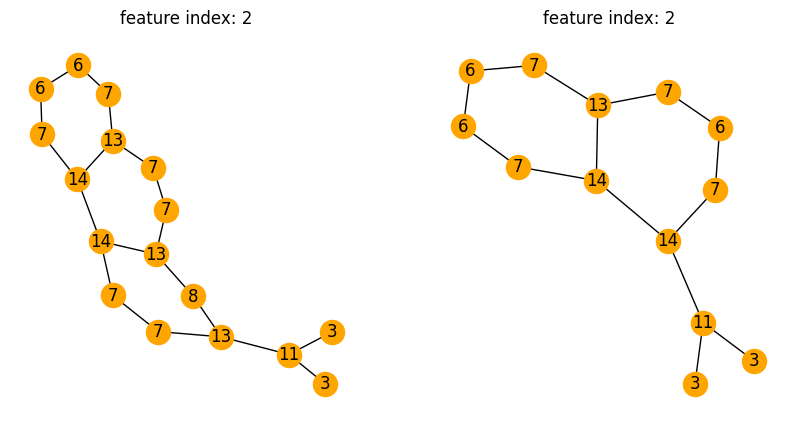

In [72]:
# apply our function to the graph data items in the dataset
enriched_dataset = TUDataset(root='data/TUDataset', name='MUTAG', transform=add_local_counting_features)

draw_graph_with_feature_vector(enriched_dataset[:2], 2)

**finally, test during training:**

train and evaluate the model on the enriched dataset
gere we use the GraphConv layer as `conv_layer_cls`
but feel free to use your own implementation,
or other layers from Pytorch Geometric.

In [75]:
model_our2 = GraphNetModel(
    enriched_dataset.num_features, 
    enriched_dataset.num_classes,
    conv_layer_cls=gnn.GraphConv)

trained_model_our2, val_accuracy_our2 = train_and_eval(model_our2, enriched_dataset)

print("Model size:", sum(p.numel() for p in model_our2.parameters()))
print("Best Accuracy:", val_accuracy_our2)

Epoch: 100 | Val Acc: 0.769 | Train Acc: 0.800 | Train Loss: 0.413 | : 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]                           

Model size: 2370
Best Accuracy: 0.7689473628997803


### [UPDATE] So, are outputs identical if the graphs are clearly not isomorphic?

Now, we can test if added features now breaked the symmetry, so that the model can distinguish between the two graphs since we added the substructure count as a feature. We test on our two graphs again:


In [78]:
model_our2.eval()

# only one batch
batch = torch.zeros(6).long()

logits_G = model_our2(data_G.x, data_G.edge_index, batch)
logits_H = model_our2(data_H.x, data_H.edge_index, batch)

print("Prediction for G: ", logits_G.detach().numpy())
print("Prediction for H:", logits_H.detach().numpy())

Prediction for G:  [[ 0.85070705 -0.6720743 ]]
Prediction for H: [[-2.5188653  2.8801498]]


## [TASK 2] (Optional) Implement a 2-WL Graph Convolutional Neural Network Layer
Now, it's time to head back to the `GraphNetModel` and `train_and_eval` functions. Seize this opportunity to devise a more expressive model!.s

This step is optional but highly encouraged. By refining and optimizing your model, you not only enhance its performance but also deepen your understanding of the inner workings of Graph Neural Networks. So go ahead, push your boundaries and let's see how much your model can achieve!

[*] Text sections INFO1-INFO5 were mostly adapted from Pytorch Documentation, please visit [PyG Colab Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html) for more information.
